In [ ]:
!pip install opendatasets
import opendatasets as od
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from transformers import pipeline
import torch
import torchvision
import opendatasets as od
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import AutoImageProcessor, AutoModel
# from datasets import load_dataset
# import keras_tuner as kt
from tensorflow.keras.preprocessing import image_dataset_from_directory
# from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
od.download("https://www.kaggle.com/datasets/anshulm257/rice-disease-dataset/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: feliciaaudrey
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/anshulm257/rice-disease-dataset


100%|██████████| 0.99G/0.99G [00:09<00:00, 109MB/s]


In [ ]:
data_dir = "rice-disease-dataset/Rice_Leaf_AUG"
img_height = 224
img_width = 224
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_size = 0.5
val_ds = temp_ds.take(int(len(temp_ds) * val_size))
test_ds = temp_ds.skip(int(len(temp_ds) * val_size))

images, labels = next(iter(train_ds))
class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)
print(f"Train batches: {len(train_ds)}")
print(f"Val batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Found 3829 files belonging to 6 classes.
Using 2681 files for training.
Found 3829 files belonging to 6 classes.
Using 1148 files for validation.
Classes: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Sheath Blight']
Train batches: 84
Val batches: 18
Test batches: 18


In [ ]:
def print_class_distribution(dataset, name):
    class_counts = [0] * len(class_names)
    for image_batch, label_batch in dataset:
        for label in label_batch:
            label_value = int(label.numpy())
            class_counts[label_value] += 1
    print(f"Class distribution for {name}:")
    for i, count in enumerate(class_counts):
        print(f"  {class_names[i]}: {count}")

print_class_distribution(train_ds, "Train")
print_class_distribution(val_ds, "Validation")
print_class_distribution(test_ds, "Test")

Class distribution for Train:
  Bacterial Leaf Blight: 452
  Brown Spot: 467
  Healthy Rice Leaf: 458
  Leaf Blast: 428
  Leaf scald: 432
  Sheath Blight: 444
Class distribution for Validation:
  Bacterial Leaf Blight: 79
  Brown Spot: 90
  Healthy Rice Leaf: 106
  Leaf Blast: 108
  Leaf scald: 94
  Sheath Blight: 99
Class distribution for Test:
  Bacterial Leaf Blight: 99
  Brown Spot: 81
  Healthy Rice Leaf: 97
  Leaf Blast: 100
  Leaf scald: 102
  Sheath Blight: 93


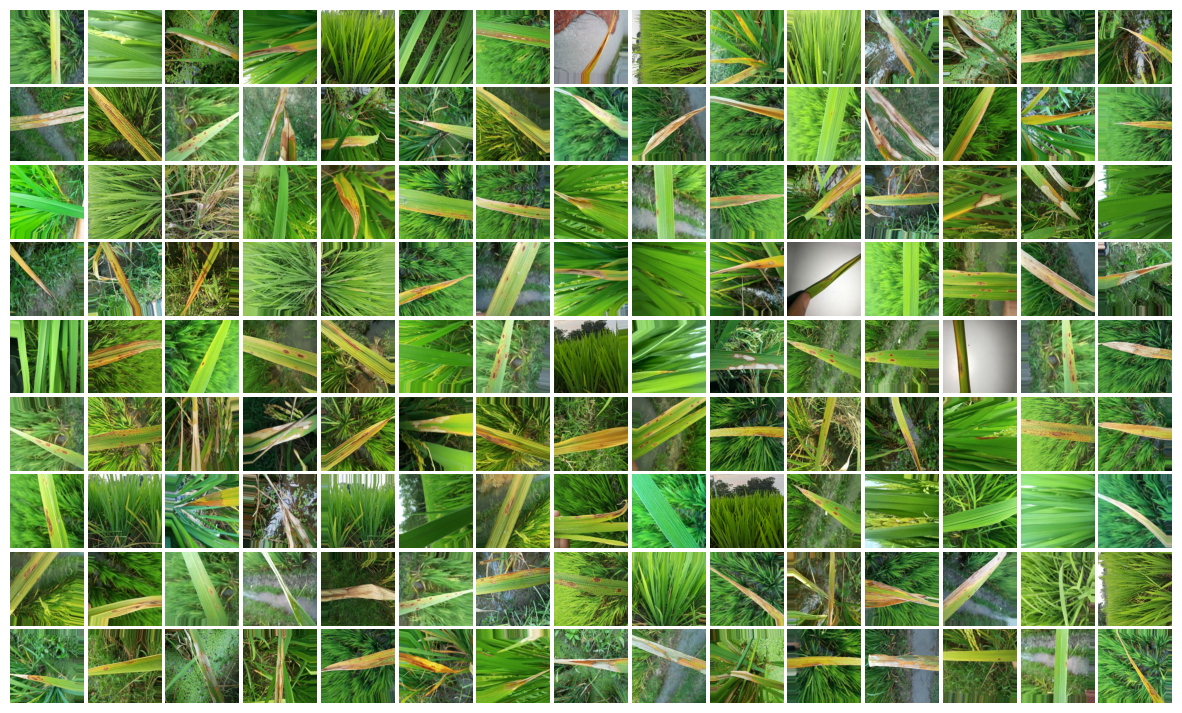

In [ ]:
needed = 9 * 15
images_list = []
labels_list = []

for images, labels in train_ds:
    images_list.append(images.numpy().astype("uint8"))
    labels_list.append(labels.numpy())
    if sum(len(x) for x in images_list) >= needed:
        break

images = np.concatenate(images_list, axis=0)[:needed]
labels = np.concatenate(labels_list, axis=0)[:needed]

rows, cols = 9, 15
fig, axes = plt.subplots(rows, cols, figsize=(15, 9))

idx = 0
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(images[idx])
        axes[i, j].axis("off")
        idx += 1

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()


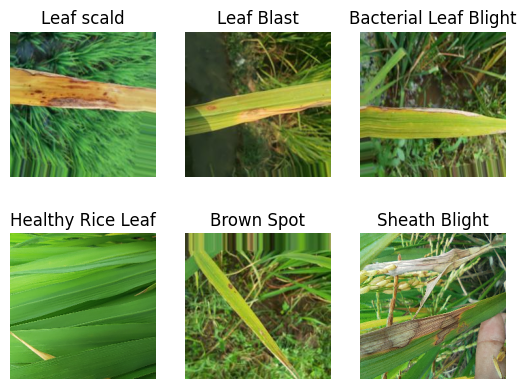

In [ ]:
shown_classes = set()
i = 1
for img, label in zip(images, labels):
    class_name = class_names[label]
    if class_name not in shown_classes:
        plt.subplot(2, (num_classes+1)//2, i)  # 2 baris
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(class_name)
        plt.axis("off")
        shown_classes.add(class_name)
        i += 1
    if len(shown_classes) == num_classes:
        break

plt.show()

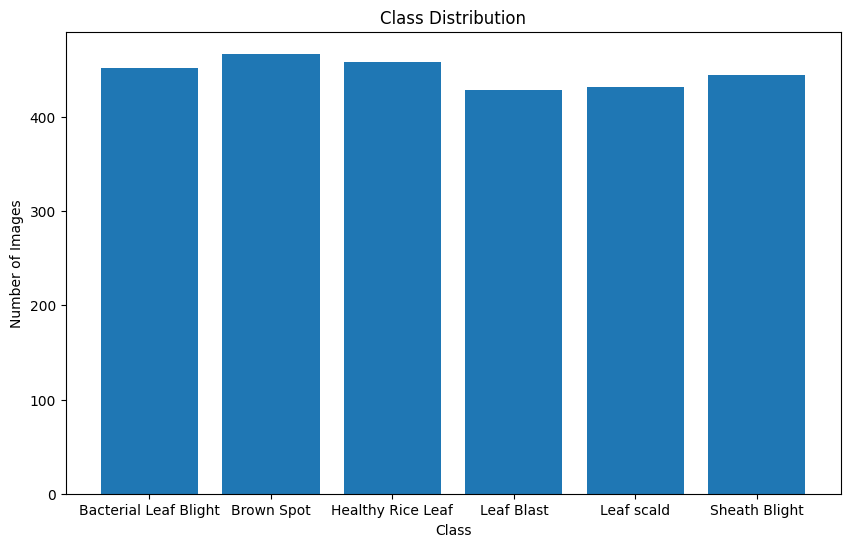

In [ ]:
def plot_class_distribution(dataset):
    class_counts = [0] * len(dataset.class_names)

    for image_batch, label_batch in dataset:
        for label in label_batch:
            label_value = int(label.numpy())
            class_counts[label_value] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(dataset.class_names, class_counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

plot_class_distribution(train_ds)

In [ ]:
def augment_images_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    image = tf.image.random_brightness(image, 0.3)
    return image, label


train_ds = train_ds.map(augment_images_train)

In [ ]:
images, labels = next(iter(train_ds))

num_images = 5
plt.figure(figsize=(15, 6))

for i in range(num_images):
    # Original
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # Augmented
    aug_img, _ = augment_images_train(images[i], labels[i])
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(tf.clip_by_value(aug_img, 0, 255).numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis("off")

plt.show()

### Model 1: EFFICIENTNETB0

In [ ]:
# MODEL 1: EFFICIENTNETB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model1 = Model(inputs=base_model.input, outputs=predictions)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


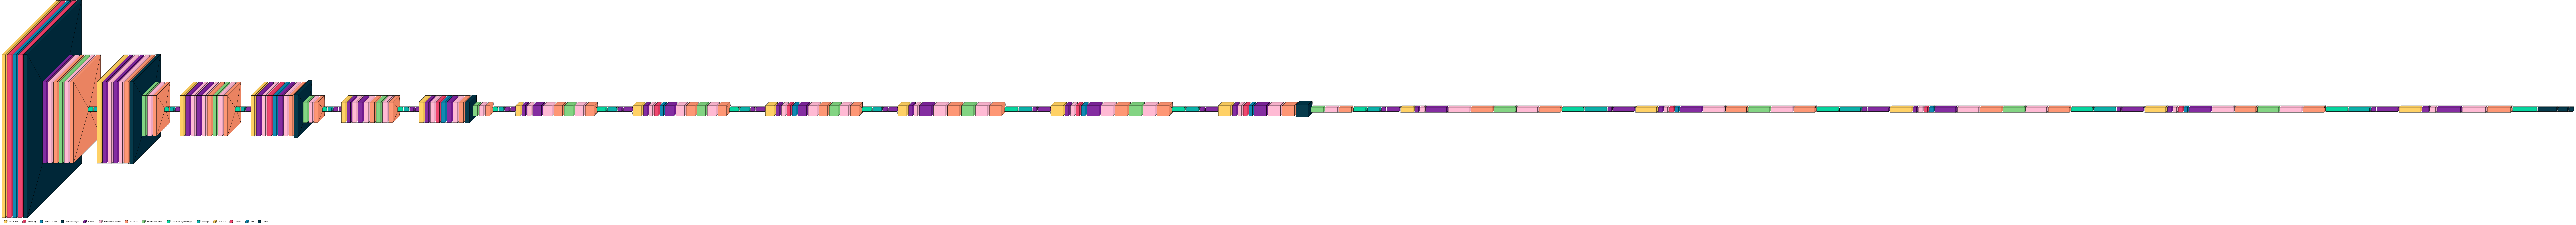

In [ ]:
import visualkeras

visualkeras.layered_view(model1, legend=True, to_file='efficientnetb0_block.png')


In [ ]:
!git clone https://github.com/HarisIqbal88/PlotNeuralNet.git
%cd PlotNeuralNet/pyexamples

Cloning into 'PlotNeuralNet'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 300 (delta 81), reused 72 (delta 72), pack-reused 194 (from 1)
Receiving objects: 100% (300/300), 2.28 MiB | 32.81 MiB/s, done.
Resolving deltas: 100% (136/136), done.
/content/PlotNeuralNet/pyexamples


In [ ]:
%cd /content/PlotNeuralNet/pyexamples


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)

In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history1 = model1.fit(train_ds,
                      epochs=50,
                      validation_data=val_ds,
                      verbose = 1,
                      callbacks=[early_stopping])

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 73s 425ms/step - accuracy: 0.4474 - loss: 1.4373 - val_accuracy: 0.6962 - val_loss: 0.8229
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.7489 - loss: 0.7371 - val_accuracy: 0.7413 - val_loss: 0.6247
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.8169 - loss: 0.5276 - val_accuracy: 0.8142 - val_loss: 0.5079
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.8785 - loss: 0.4049 - val_accuracy: 0.8576 - val_loss: 0.4151
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 208ms/step - accuracy: 0.9155 - loss: 0.3125 - val_accuracy: 0.8958 - val_loss: 0.3537
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.9363 - loss: 0.2419 - val_accuracy: 0.8819 - val_loss: 0.3586
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.9556 - loss: 0.1880 - val_accuracy: 0.9201 - val_loss: 0.2702
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.9642 - loss: 0.1628 - val_accu

In [ ]:
history1 = model1.fit(train_ds,
                      epochs=15,
                      validation_data=val_ds,
                      verbose = 1,
                      )

Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.9996 - loss: 0.0111 - val_accuracy: 0.9340 - val_loss: 0.1862
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - accuracy: 0.9967 - loss: 0.0160 - val_accuracy: 0.9340 - val_loss: 0.1886
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.9971 - loss: 0.0155 - val_accuracy: 0.9375 - val_loss: 0.1861
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.9966 - loss: 0.0177 - val_accuracy: 0.9340 - val_loss: 0.2304
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9931 - loss: 0.0226 - val_accuracy: 0.9115 - val_loss: 0.2921
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.9919 - loss: 0.0202 - val_accuracy: 0.9444 - val_loss: 0.1603
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.9946 - loss: 0.0234 - val_accuracy: 0.9549 - val_loss: 0.1624
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.9972 - loss: 0.0147 - val_accu

In [ ]:
test_loss, test_acc = model1.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.9493 - loss: 0.1870
Test Accuracy: 0.9458
Test Loss: 0.1915


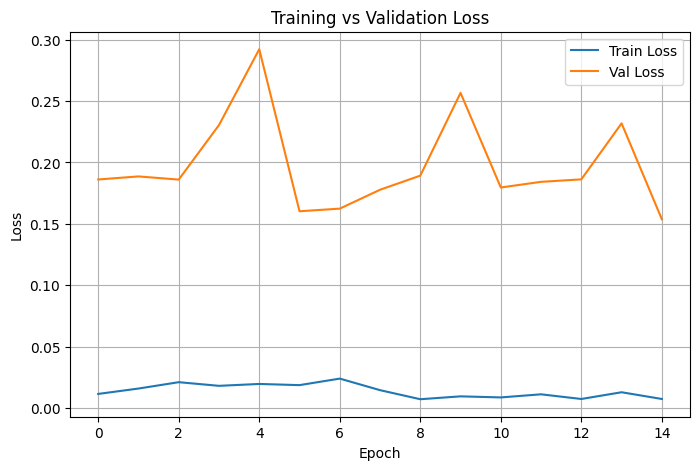

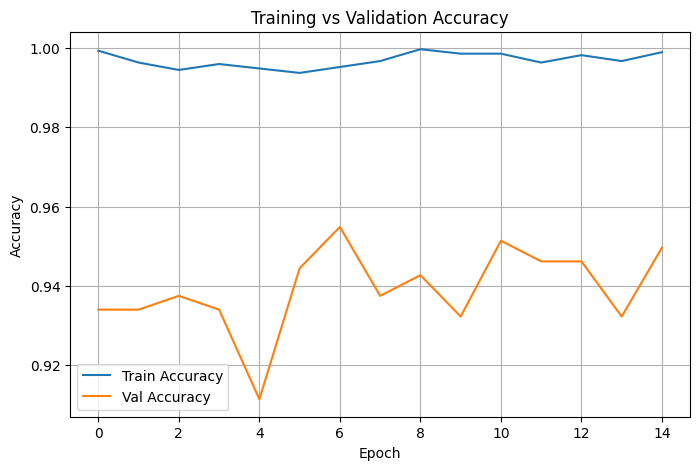

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 2: ResNet50

In [ ]:
from tensorflow.keras.applications import ResNet50

# Model 2
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)

In [ ]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history2 = model2.fit(train_ds,
                      epochs=10,
                      validation_data=val_ds,
                      verbose=1,
                      callbacks=[early_stopping])

Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 259ms/step - accuracy: 0.4807 - loss: 1.3249 - val_accuracy: 0.7483 - val_loss: 0.7493
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - accuracy: 0.8172 - loss: 0.5648 - val_accuracy: 0.8247 - val_loss: 0.5172
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.8874 - loss: 0.3677 - val_accuracy: 0.8247 - val_loss: 0.4891
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 174ms/step - accuracy: 0.9111 - loss: 0.2940 - val_accuracy: 0.8802 - val_loss: 0.3654
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9531 - loss: 0.1942 - val_accuracy: 0.8785 - val_loss: 0.3475
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - accuracy: 0.9803 - loss: 0.1307 - val_accuracy: 0.8976 - val_loss: 0.3134
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - accuracy: 0.9859 - loss: 0.0914 - val_accuracy: 0.9340 - val_loss: 0.2307
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.9976 - loss: 0.0606 - val_accu

In [ ]:
test_loss, test_acc = model2.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.9034 - loss: 0.2582
Test Accuracy: 0.9108
Test Loss: 0.2485


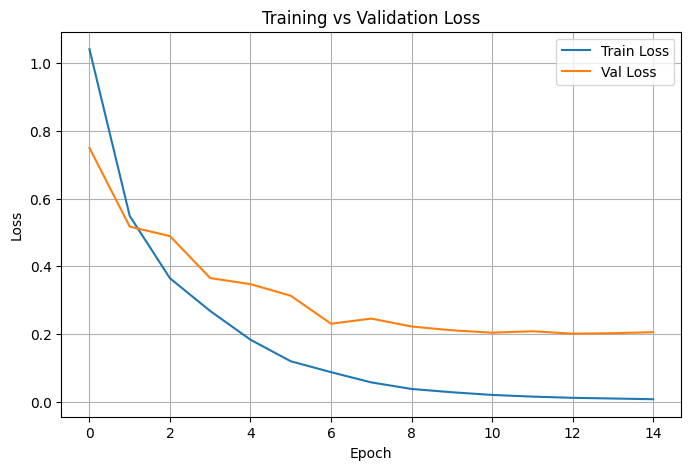

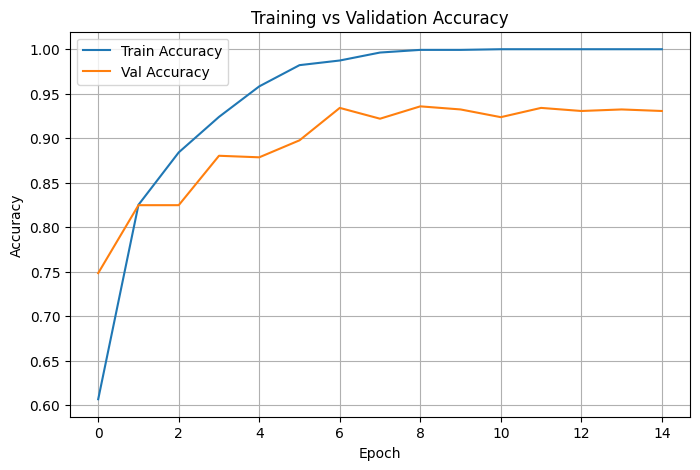

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 3: InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Model 3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model3 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)

In [ ]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history3 = model3.fit(train_ds,
                      epochs=15,
                      validation_data=val_ds,
                      verbose=1,
                      callbacks=[early_stopping])

Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 358ms/step - accuracy: 0.2604 - loss: 7.7664 - val_accuracy: 0.3958 - val_loss: 2.8856
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.4657 - loss: 1.9889 - val_accuracy: 0.4358 - val_loss: 2.2839
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 179ms/step - accuracy: 0.5150 - loss: 1.6357 - val_accuracy: 0.4774 - val_loss: 1.9764
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.5992 - loss: 1.2600 - val_accuracy: 0.4549 - val_loss: 2.1551
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.6070 - loss: 1.2505 - val_accuracy: 0.4965 - val_loss: 1.8682
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.6945 - loss: 0.9262 - val_accuracy: 0.5208 - val_loss: 1.7637
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.7327 - loss: 0.7844 - val_accuracy: 0.5399 - val_loss: 1.6750
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.7596 - loss: 0.6557 - val_accu

In [ ]:
test_loss, test_acc = model3.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6136 - loss: 1.2535
Test Accuracy: 0.6329
Test Loss: 1.2074


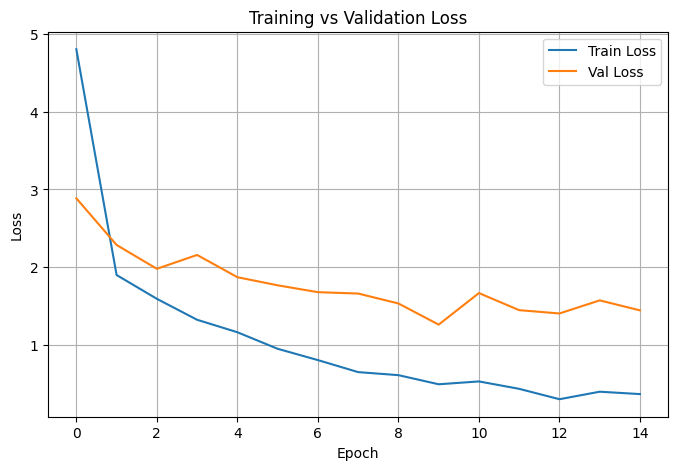

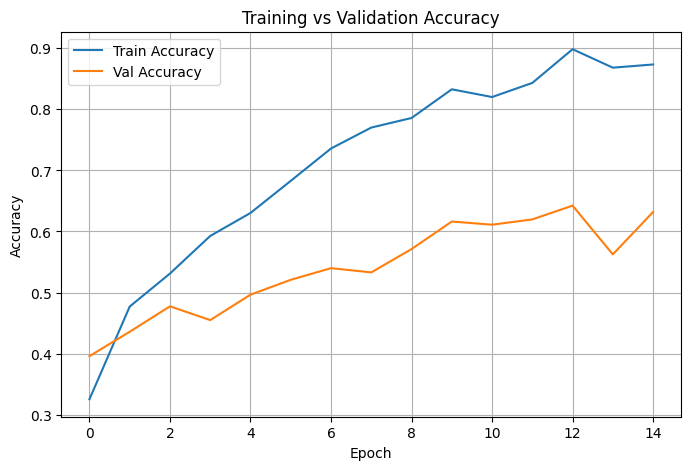

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 4: MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Model 4
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model4 = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)

In [ ]:
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history4 = model4.fit(train_ds,
                      epochs=15,
                      validation_data=val_ds,
                      verbose=1,
                      callbacks=[early_stopping])

Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 347ms/step - accuracy: 0.4035 - loss: 1.5186 - val_accuracy: 0.5208 - val_loss: 1.2728
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 202ms/step - accuracy: 0.5644 - loss: 1.1235 - val_accuracy: 0.5243 - val_loss: 1.2166
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.6411 - loss: 0.9840 - val_accuracy: 0.5920 - val_loss: 1.1023
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.6940 - loss: 0.8851 - val_accuracy: 0.5729 - val_loss: 1.1078
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.6951 - loss: 0.8361 - val_accuracy: 0.6406 - val_loss: 0.9787
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.7426 - loss: 0.7287 - val_accuracy: 0.6701 - val_loss: 0.8995
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.7673 - loss: 0.6901 - val_accuracy: 0.6910 - val_loss: 0.8617
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - accuracy: 0.7818 - loss: 0.6417 - val_accu

In [ ]:
test_loss, test_acc = model4.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 740ms/step - accuracy: 0.7079 - loss: 0.8490
Test Accuracy: 0.7045
Test Loss: 0.8206


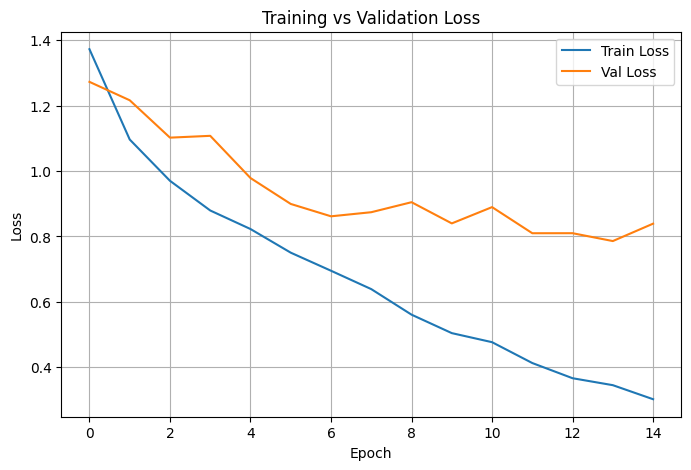

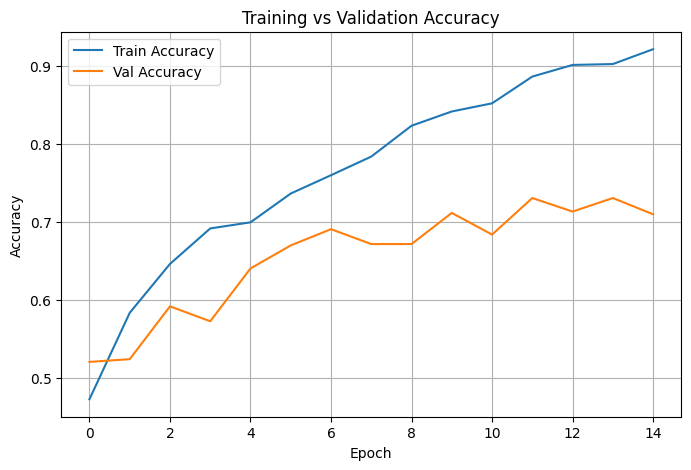

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 5: DenseNet121

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Model 5
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model5 = Model(inputs=base_model.input, outputs=predictions)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=1e-6)

In [ ]:
model5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history5 = model5.fit(train_ds,
                      epochs=15,
                      validation_data=val_ds,
                      verbose=1,
                      callbacks=[early_stopping])

Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 69s 504ms/step - accuracy: 0.3971 - loss: 1.8931 - val_accuracy: 0.5868 - val_loss: 1.3110
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 180ms/step - accuracy: 0.6826 - loss: 0.9227 - val_accuracy: 0.6580 - val_loss: 0.9701
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.7255 - loss: 0.7680 - val_accuracy: 0.6458 - val_loss: 1.0221
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.7737 - loss: 0.6615 - val_accuracy: 0.7552 - val_loss: 0.7677
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 178ms/step - accuracy: 0.8077 - loss: 0.5567 - val_accuracy: 0.7326 - val_loss: 0.7773
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - accuracy: 0.8344 - loss: 0.4794 - val_accuracy: 0.7344 - val_loss: 0.7632
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.8594 - loss: 0.4481 - val_accuracy: 0.7500 - val_loss: 0.7472
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.8624 - loss: 0.4167 - val_accu

In [ ]:
test_loss, test_acc = model5.evaluate(test_ds, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 858ms/step - accuracy: 0.7914 - loss: 0.5725
Test Accuracy: 0.8112
Test Loss: 0.5382


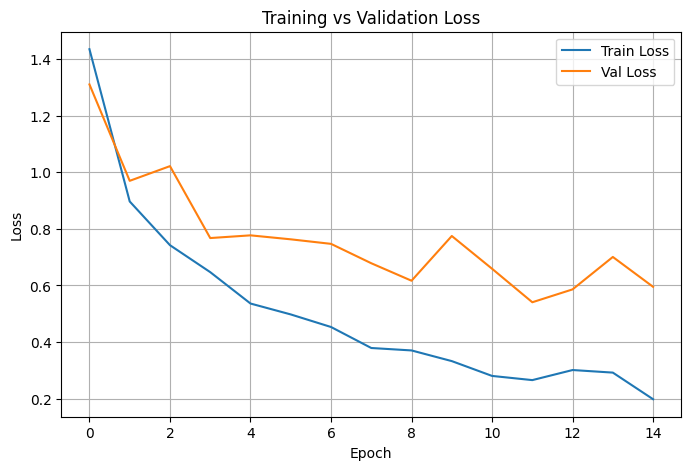

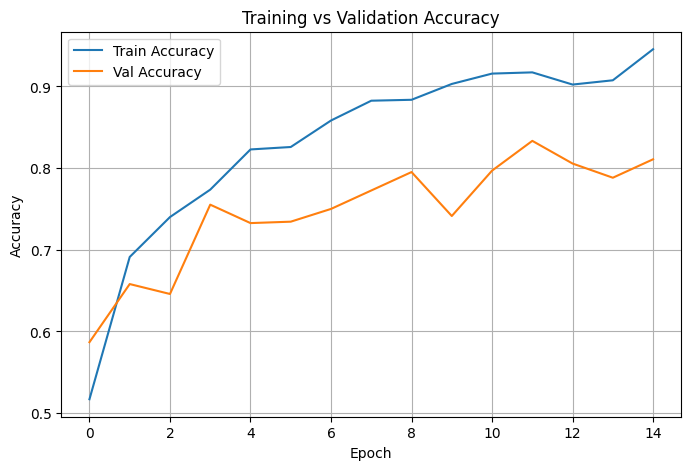

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Model 6: DinoV2 (SoTA)

In [ ]:
%%capture

!pip install torch torchvision transformers timm

In [ ]:
train_dir = "rice-disease-dataset/Rice_Leaf_AUG/train"
val_dir   = "rice-disease-dataset/Rice_Leaf_AUG/val"
test_dir  = "rice-disease-dataset/Rice_Leaf_AUG/test"

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Load semua data
dataset = datasets.ImageFolder("rice-disease-dataset/Rice_Leaf_AUG", transform=transform)

# Bikin index train/val/test
train_idx, temp_idx = train_test_split(list(range(len(dataset))), test_size=0.3, stratify=dataset.targets, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[dataset.targets[i] for i in temp_idx], random_state=42)

train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)
test_ds  = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Sheath Blight']


#### Model DinoV2

In [ ]:
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
backbone = AutoModel.from_pretrained("facebook/dinov2-base")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
class DinoClassifier(nn.Module):
    def __init__(self, backbone, hidden_dim=768, num_classes=num_classes):
        super().__init__()
        self.backbone = backbone
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0, :]
        return self.fc(cls_token)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DinoClassifier(backbone, hidden_dim=768, num_classes=num_classes).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
from tqdm import tqdm

EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs = processor(images=[transforms.ToPILImage()(img) for img in imgs],
                           return_tensors="pt").to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs["pixel_values"])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Train Loss: {train_loss/total:.4f}, Train Acc: {acc:.4f}")

Epoch 1/10: 100%|██████████| 84/84 [02:35<00:00,  1.85s/it]


Train Loss: 0.6038, Train Acc: 0.7888


Epoch 2/10: 100%|██████████| 84/84 [02:36<00:00,  1.86s/it]


Train Loss: 0.5858, Train Acc: 0.7970


Epoch 3/10: 100%|██████████| 84/84 [02:36<00:00,  1.86s/it]


Train Loss: 0.4480, Train Acc: 0.8437


Epoch 4/10: 100%|██████████| 84/84 [02:35<00:00,  1.85s/it]


Train Loss: 0.3756, Train Acc: 0.8698


Epoch 5/10: 100%|██████████| 84/84 [02:36<00:00,  1.86s/it]


Train Loss: 0.3680, Train Acc: 0.8668


Epoch 6/10: 100%|██████████| 84/84 [02:36<00:00,  1.86s/it]


Train Loss: 0.2174, Train Acc: 0.9306


Epoch 7/10: 100%|██████████| 84/84 [02:37<00:00,  1.88s/it]


Train Loss: 0.2357, Train Acc: 0.9231


Epoch 8/10: 100%|██████████| 84/84 [02:35<00:00,  1.85s/it]


Train Loss: 0.2271, Train Acc: 0.9261


Epoch 9/10: 100%|██████████| 84/84 [02:35<00:00,  1.85s/it]


Train Loss: 0.1845, Train Acc: 0.9381


Epoch 10/10: 100%|██████████| 84/84 [02:34<00:00,  1.84s/it]

Train Loss: 0.1635, Train Acc: 0.9410


In [ ]:
def evaluate(loader):
    model.eval()
    correct, total, eval_loss = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            inputs = processor(images=[transforms.ToPILImage()(img) for img in imgs],
                               return_tensors="pt").to(device)
            labels = labels.to(device)
            outputs = model(inputs["pixel_values"])
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return eval_loss/total, correct/total

val_loss, val_acc = evaluate(val_loader)
print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

test_loss, test_acc = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Validation Loss: 0.6336, Validation Acc: 0.8049
Test Loss: 0.5726, Test Acc: 0.8122
